<a href="https://colab.research.google.com/github/OswaldVc/AnaDat/blob/main/Ventas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

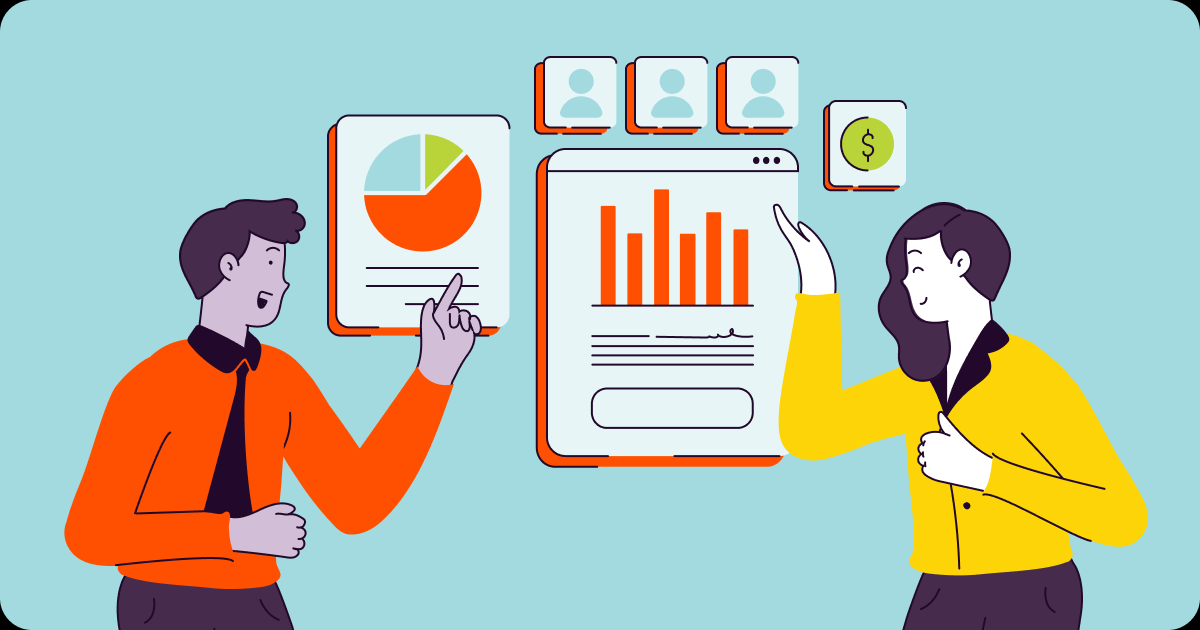

###  ***By Néstor O. Vásquez C.***

### **Librerias**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.ticker import ScalarFormatter, FuncFormatter
from scipy.stats import fisher_exact

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
sns.set(style="white")

# --- Global variables ---
RANDOM_STATE = 42
SIGNIFICANCE_LEVEL = 0.05

### **EDA**

In [2]:
Ventas = pd.read_csv('https://raw.githubusercontent.com/OswaldVc/AnaDat/main/KAG_conversion_data.csv')
Ventas.head(3)

,ad_id,xyz_campaign_id,fb_campaign_id,age,gender,interest,Impressions,Clicks,Spent,Total_Conversion,Approved_Conversion
0,708746,916,103916,30-34,M,15,7350,1,1.43,2,1
1,708749,916,103917,30-34,M,16,17861,2,1.82,2,0
2,708771,916,103920,30-34,M,20,693,0,0.00,1,0


In [3]:
Ventas.rename(columns={
    'ad_id': 'id',
    'xyz_campaign_id': 'id_campaña_xyz',
    'fb_campaign_id': 'id_campaña_fb',
    'age': 'edad',
    'gender': 'genero',
    'interest': 'interes',
    'Impressions': 'impresiones',
    'Clicks': 'Clicks',
    'Spent': 'gasto',
    'Total_Conversion': 'conversion_total',
    'Approved_Conversion': 'conversion_aprobada'
}, inplace=True)


In [4]:
Ventas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1143 entries, 0 to 1142
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   1143 non-null   int64  
 1   id_campaña_xyz       1143 non-null   int64  
 2   id_campaña_fb        1143 non-null   int64  
 3   edad                 1143 non-null   object 
 4   genero               1143 non-null   object 
 5   interes              1143 non-null   int64  
 6   impresiones          1143 non-null   int64  
 7   Clicks               1143 non-null   int64  
 8   gasto                1143 non-null   float64
 9   conversion_total     1143 non-null   int64  
 10  conversion_aprobada  1143 non-null   int64  
dtypes: float64(1), int64(8), object(2)
memory usage: 98.4+ KB


In [5]:
# --- Estadisticas básicas --- #

pd.DataFrame(
    {
        'Tipo de Dato': Ventas.dtypes,
        'Cantidad de Faltantes (#)': Ventas.isnull().sum(),
        'Tasa de Faltantes (%)': 100 * Ventas.isnull().mean(),
        'Cantidad Única (#)': Ventas.nunique(),
        'Tasa Única (%)': round(100 * Ventas.nunique() / Ventas.shape[0], 2),
        'Cantidad de Duplicados (#)': [Ventas[c].duplicated().sum() for c in Ventas.columns],
        'Tasa de Duplicados (%)': [round(100 * Ventas[c].duplicated().sum() / Ventas.shape[0], 2) for c in Ventas.columns],
    }
)

,Tipo de Dato,Cantidad de Faltantes (#),Tasa de Faltantes (%),Cantidad Única (#),Tasa Única (%),Cantidad de Duplicados (#),Tasa de Duplicados (%)
id,int64,0,0.0,1143,100.00,0,0.00
id_campaña_xyz,int64,0,0.0,3,0.26,1140,99.74
id_campaña_fb,int64,0,0.0,691,60.45,452,39.55
edad,object,0,0.0,4,0.35,1139,99.65
genero,object,0,0.0,2,0.17,1141,99.83
interes,int64,0,0.0,40,3.50,1103,96.50
impresiones,int64,0,0.0,1130,98.86,13,1.14
Clicks,int64,0,0.0,183,16.01,960,83.99
gasto,float64,0,0.0,869,76.03,274,23.97
conversion_total,int64,0,0.0,32,2.80,1111,97.20


>> 1. No faltan valores en el conjunto de datos.
>> 2. El conjunto de datos contiene datos de 1143 altas.
>> 3. Sólo hay 3 campañas xyz en el conjunto de datos.
>> 4. Hay 691 campañas de Facebook en el conjunto de datos.
>> 5. Los clientes están segmentados en 4 grupos de edad.

In [6]:
Ventas_numericas = Ventas.select_dtypes(include=['int64', 'float64'])
Ventas_numericas.describe().apply(lambda s: s.apply(lambda x: f"{x:,.2f}"))

,id,id_campaña_xyz,id_campaña_fb,interes,impresiones,Clicks,gasto,conversion_total,conversion_aprobada
count,"1,143.00","1,143.00","1,143.00","1,143.00","1,143.00","1,143.00","1,143.00","1,143.00","1,143.00"
mean,"987,261.13","1,067.38","133,783.99",32.77,"186,732.13",33.39,51.36,2.86,0.94
std,"193,992.81",121.63,"20,500.31",26.95,"312,762.18",56.89,86.91,4.48,1.74
min,"708,746.00",916.00,"103,916.00",2.00,87.00,0.00,0.00,0.00,0.00
25%,"777,632.50",936.00,"115,716.00",16.00,"6,503.50",1.00,1.48,1.00,0.00
50%,"1,121,185.00","1,178.00","144,549.00",25.00,"51,509.00",8.00,12.37,1.00,1.00
75%,"1,121,804.50","1,178.00","144,657.50",31.00,"221,769.00",37.50,60.02,3.00,1.00
max,"1,314,415.00","1,178.00","179,982.00",114.00,"3,052,003.00",421.00,639.95,60.00,21.00


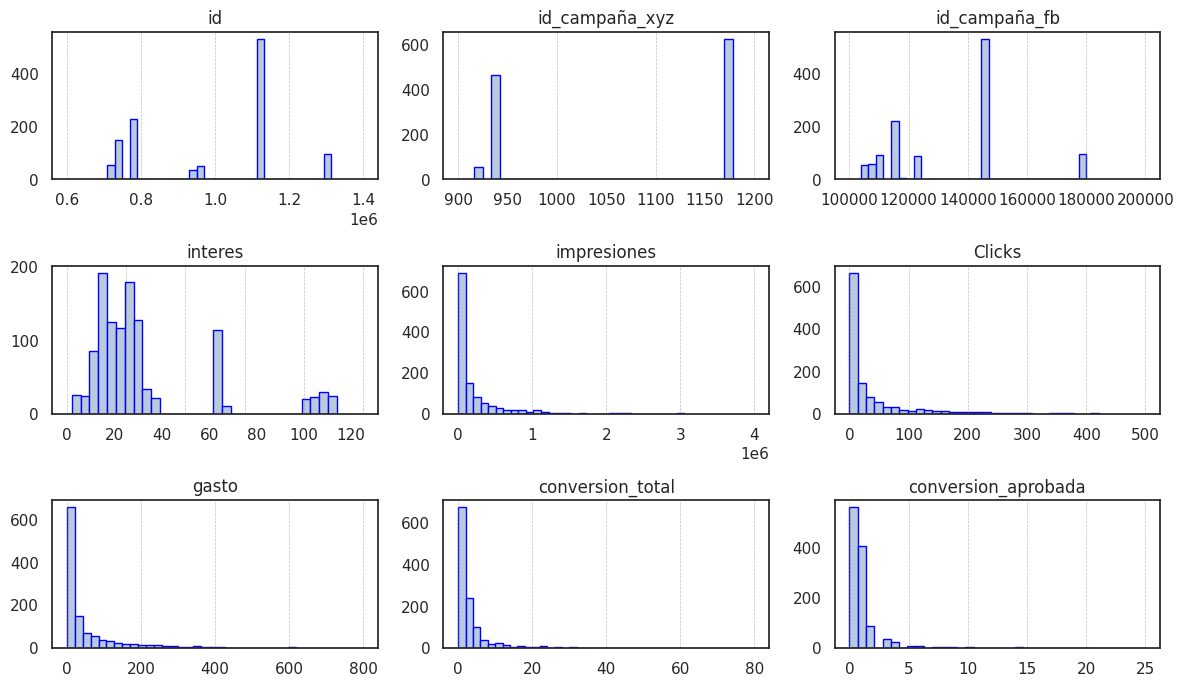

In [14]:
# Crear una figura con 3x3 subgráficas y tamaño específico (ancho=12, alto=7)
fig, axes = plt.subplots(3, 3, figsize=(12, 7))
axes = axes.flatten()

# Color azul que se usará para todas las gráficas
blue_color = '#b9cada'  # Azul estándar de matplotlib

for i, col in enumerate(Ventas_numericas):
    ax = axes[i]
    ax.hist(Ventas[col].dropna(), bins=30, color=blue_color, edgecolor='Blue')
    ax.set_title(col)

    # Desactivar la notación científica en el eje y.
    ax.yaxis.set_major_formatter(ScalarFormatter(useOffset=False))
    ax.ticklabel_format(style='plain', axis='y')

    for tick in ax.get_xticks():
        if tick < 0: continue
        ax.axvline(x=tick, color='grey', alpha=0.5, linestyle='--', linewidth=0.5)

# Ocultar las subgráficas no utilizadas
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout(pad=1.0)
plt.show()

In [8]:
Ventas_Categoricas = Ventas.select_dtypes(exclude=['int64', 'float64'])
Ventas_Categoricas.value_counts()

edad   genero
30-34  M         229
       F         197
35-39  M         139
45-49  F         138
       M         121
35-39  F         109
40-44  F         107
       M         103
Name: count, dtype: int64

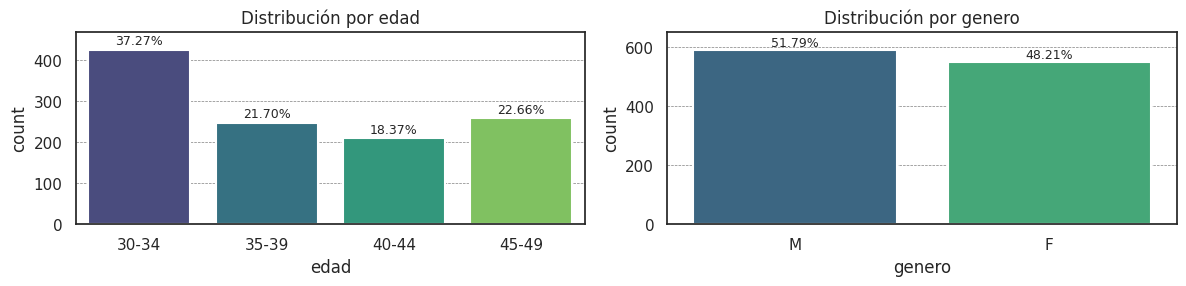

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(12, 3))
axes = axes.flatten()

for i, col in enumerate(Ventas_Categoricas):
    ax = axes[i]

    plot = sns.countplot(data=Ventas, x=col,
                         palette='viridis', edgecolor='white', linewidth=1.5,
                         ax=ax)
    ax.set_title(f'Distribución por {col}')
    ax.grid(axis='y', color='grey', linestyle='--', linewidth=0.5)

    # Añade un porcentaje en la parte superior de cada barra.
    total = len(Ventas[col])
    max_height = 0
    for p in plot.patches:
        height = p.get_height()
        max_height = max(max_height, height)
        percentage = 100 * height / total
        ax.text(p.get_x() + p.get_width() / 2., height + 12,
                f'{percentage:.2f}%', ha='center', fontsize=9)

    ax.set_ylim(0, max_height * 1.10)


for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout(pad=1.0)
plt.show()

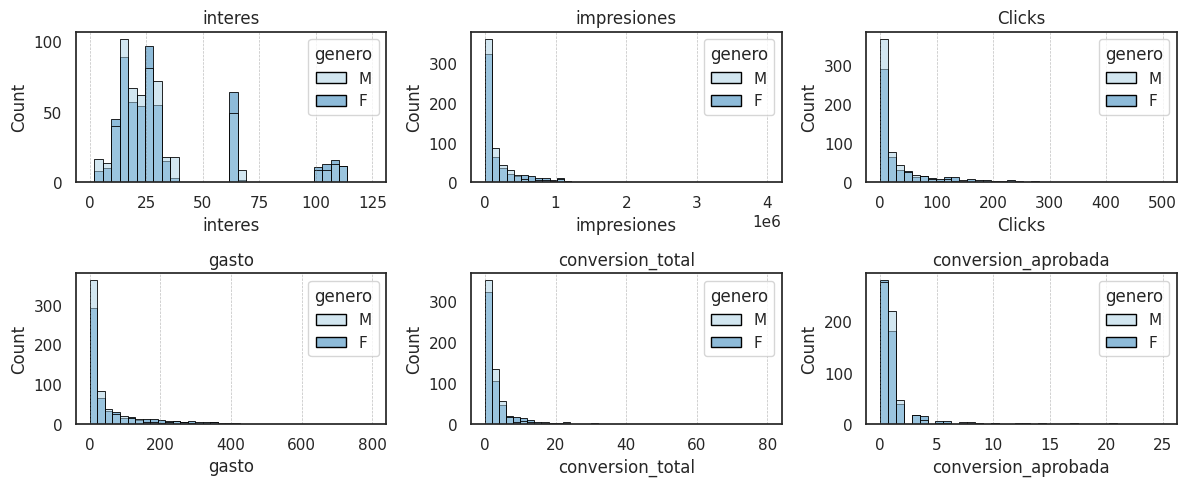

In [13]:
fig, axes = plt.subplots(2, 3, figsize=(12, 5))
axes = axes.flatten()

colors = sns.color_palette("Paired", 9)

for i, col in enumerate([x for x in Ventas_numericas if x not in ['id', 'id_campaña_xyz', 'id_campaña_fb']]):
    ax = axes[i]
    sns.histplot(data=Ventas, x=col, hue='genero', bins=30, palette="Paired", ax=ax, edgecolor='black')
    ax.set_title(col)

    # Desactiva la notación científica en el eje y.
    ax.yaxis.set_major_formatter(ScalarFormatter(useOffset=False))
    ax.ticklabel_format(style='plain', axis='y')

    for tick in ax.get_xticks():
        if tick < 0: continue
        ax.axvline(x=tick, color='grey', alpha=0.5, linestyle='--', linewidth=0.5)

for j in range(i + 1, len(axes)): axes[j].set_visible(False)

plt.tight_layout(pad=1.0)
plt.show()

<P align="justify">Ahora compararemos la proporción de hombres frente a mujeres dentro de cada campaña (id_campaña_xyz). Para comprobar si existe una diferencia significativa en la distribución por sexos (hombres frente a mujeres) de cada campaña vamos a utilizar la prueba exacta de Fisher. La hipótesis nula ( H0 ) y la hipótesis alternativa ( H1 ) son las siguientes:<P/>

>> **H0:** <P align="justify"> No existe asociación entre el sexo (masculino o femenino) y la campaña. En otras palabras, la distribución de hombres y mujeres en la campaña se debe al azar. La proporción de hombres y mujeres es la misma en toda la campaña.<P/>

>> **H1:** <P align="justify">  Existe una asociación significativa entre el género y la campaña. Esto significa que la distribución de hombres y mujeres dentro de la campaña difiere de lo que cabría esperar por azar. La proporción de hombres y mujeres difiere en esta campaña.<P/>


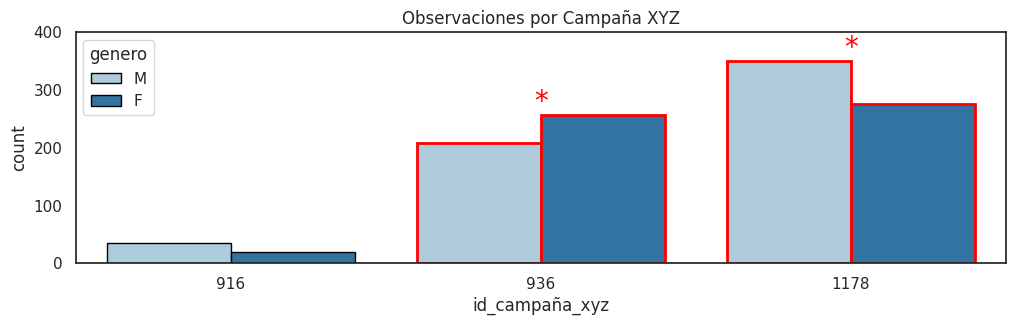

In [11]:
# Crear una figura con tamaño específico (ancho=12, alto=3)
plt.figure(figsize=(12, 3))

# Generar un gráfico de conteo que muestra la distribución de 'id_campaña_xyz',
# diferenciada por 'genero'. Las barras tendrán bordes negros para una mejor visualización.
ax = sns.countplot(data=Ventas, x='id_campaña_xyz', hue='genero', palette="Paired", edgecolor='black')
plt.title('Observaciones por Campaña XYZ')
plt.ylim((0, 400))  # Ajustar el límite del eje y para que vaya de 0 a 400

# ------------------- #
# Pruebas estadísticas #
# ------------------- #

# Lista para almacenar los índices de las campañas que muestran diferencias estadísticamente significativas
significant_campaign_idx = []

# --- Realizar la prueba exacta de Fisher para cada campaña ---
for i, campaign in enumerate(sorted(Ventas['id_campaña_xyz'].unique())):
    # Crear una tabla de contingencia que compara el género con la pertenencia a la campaña específica
    contingency_table = pd.crosstab(Ventas['genero'], Ventas['id_campaña_xyz'] == campaign)

    # Ejecutar la prueba exacta de Fisher y obtener el valor p
    _, p_value = fisher_exact(contingency_table)

    # Si el valor p es menor que el nivel de significancia, se considera que la diferencia es significativa
    if p_value < SIGNIFICANCE_LEVEL:
        significant_campaign_idx.append(i)

# Visualizar las campañas para las cuales la diferencia entre géneros es significativa
for campaign in significant_campaign_idx:
    # Identificar las barras en el gráfico que corresponden a la campaña significativa
    patches = [patch for patch in ax.patches if round(patch.get_x() + patch.get_width() / 2) == campaign]

    if patches:
        # Resaltar las barras significativas cambiando el borde a color rojo
        for patch in patches:
            patch.set_edgecolor('red')
            patch.set_linewidth(2)

        # Mostrar un asterisco para una mejor visualización.
        if len(patches) == 2:
            midpoint = (patches[0].get_x() + patches[1].get_x() + patches[0].get_width()) / 2
            plt.text(midpoint, max(p.get_height() for p in patches) - 1, '*',
                     ha='center', va='bottom', fontsize=20, color='red')

# Mostrar la gráfica resultante
plt.show()

>> Vemos que la proporción de hombres y mujeres difiere significativamente para dos campañas (id_campaña_xyz), a saber  936 y  1178.

Ahora haremos lo mismo para la categoría de Intereses. Así, comprobaremos la proporción de hombres frente a la de mujeres dentro de cada categoría de intereses.

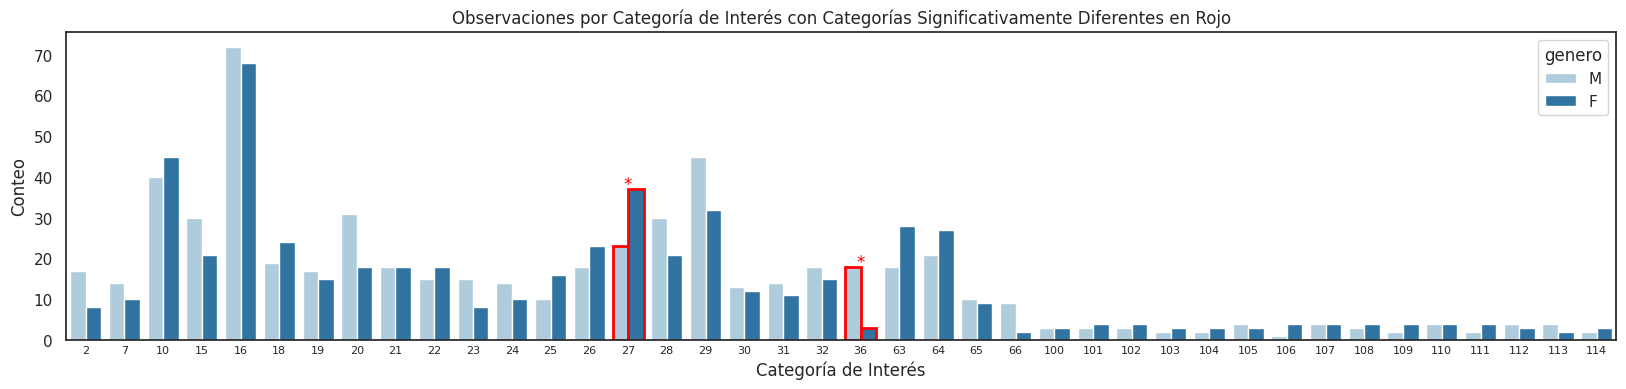

In [12]:
# -------- #
# Gráfica  #
# -------- #

plt.figure(figsize=(20, 4))

# Crear un gráfico de conteo con la categoría 'interes' en el eje x, diferenciando por 'genero'
ax = sns.countplot(data=Ventas, x='interes', hue='genero', palette="Paired")
plt.title('Observaciones por Categoría de Interés con Categorías Significativamente Diferentes en Rojo')
plt.xlabel('Categoría de Interés')
plt.ylabel('Conteo')
plt.xticks(fontsize=8)
plt.tick_params(axis='x', which='both', direction='in', length=6)

# ------------------- #
# Pruebas estadísticas #
# ------------------- #

# Lista para almacenar los índices de las categorías de interés que son estadísticamente significativas
significant_categories_idx = []

# --- Realizar la prueba exacta de Fisher para cada categoría de interés ---
for i, category in enumerate(sorted(Ventas['interes'].unique())):
    # Crear una tabla de contingencia que compara el género y la pertenencia a la categoría de interés
    contingency_table = pd.crosstab(Ventas['genero'], Ventas['interes'] == category)

    # Ejecutar la prueba exacta de Fisher
    _, p_value = fisher_exact(contingency_table)

    # Si el valor p es menor que el nivel de significancia, se agrega el índice a la lista
    if p_value < SIGNIFICANCE_LEVEL:
        significant_categories_idx.append(i)

# Visualizar las categorías de interés donde la diferencia entre géneros es significativa
for category in significant_categories_idx:
    # Identificar las barras en el gráfico que corresponden a la categoría significativa
    patches_for_category = [patch for patch in ax.patches if round(patch.get_x() + patch.get_width() / 2) == category]

    if patches_for_category:
        # Resaltar las barras significativas con un borde rojo
        for patch in patches_for_category:
            patch.set_edgecolor('red')
            patch.set_linewidth(2)

        # Si hay dos barras para la misma categoría, agregar un asterisco entre ellas para indicar significancia
        if len(patches_for_category) == 2:
            midpoint = (patches_for_category[0].get_x() + patches_for_category[1].get_x() + patches_for_category[0].get_width()) / 2
            plt.text(midpoint, max(p.get_height() for p in patches_for_category)-1, '*',
                     ha='center', va='bottom', fontsize=12, color='red')

plt.show()

>> Vemos que para dos categorías de interés pudimos rechazar la hipótesis nula **H0.**

Por lo tanto, podemos concluir que existe una asociación significativa entre el género y las categorías de interés.  27 y 36 respectivamente.